In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import ast
from itertools import zip_longest

In [2]:
def get_llm_ratings(llm_rating_sources: list[str]) -> dict[str, float]:
    llm_ratings = {}

    all_ratings = {}
    for source in llm_rating_sources:
        print(source)
        source = f"{os.path.dirname(os.path.abspath(os.getcwd()))}/../outputs/{source}"
        
        # Traverse through the directory to find CSV files
        for root, _, files in os.walk(source):
            for file in files:
                if file.endswith(".csv"):
                    # Read the CSV file
                    file_path = os.path.join(root, file)
                    df = pd.read_csv(file_path)
                    
                    # Assuming the response column contains the dictionary of ratings as string
                    for index, row in df.iterrows():
                        name = row['experiment_name'] + ", " + row['version']
                        response = row["response"]

                        response = ast.literal_eval(response)
                        question = "1"
                        rating = 0
                        if question in response:
                            rating = response["1"]
                        else:
                            continue

                        if name not in all_ratings:
                            all_ratings[name] = []
                        all_ratings[name].append(rating)
    print(all_ratings)
    
    for key, value in all_ratings.items():
        llm_ratings[key] = sum(value) / len(value)
    
    return llm_ratings

In [3]:
human_ratings = { # Standard suspense / Q2 ratings
    "Experiment A, Pen Not Mentioned": (3.78 + 3.43) / 2,
    "Experiment A, Pen Mentioned Removed": (4.38 + 4.06) / 2,
    "Experiment A, Pen Mentioned Not Removed": 3.47,
    "Experiment B, Unused Comb": 3.96,
    "Experiment B, Used Comb": 3.41,
    "Experiment C, Prior Solution Not Mentioned": (3.76 + 3.34) / 2,
    "Experiment C, Prior Solution Mentioned and Removed": (4.61 + 3.99) / 2,
    "Experiment C, Prior Solution Mentioned Not Removed": 4.14
}
# human_ratings = { # Alternate suspense / Q2 ratings
#     "Experiment A, Pen Not Mentioned": 3.40,
#     "Experiment A, Pen Mentioned Removed": 3.95,
#     "Experiment A, Pen Mentioned Not Removed": 0, # n/a
#     "Experiment B, Unused Comb": 0, # n/a
#     "Experiment B, Used Comb": 0, # n/a
#     "Experiment C, Prior Solution Not Mentioned": 3.40,
#     "Experiment C, Prior Solution Mentioned and Removed": 3.91,
#     "Experiment C, Prior Solution Mentioned Not Removed": 0 # n/a
# }

In [4]:
llm_rating_sources = ["gerrig_experiment/adversarial/synonim_swap"]
llm_ratings = get_llm_ratings(llm_rating_sources)
print(llm_ratings)

gerrig_experiment/adversarial/synonim_swap
{'Experiment A, Pen Not Mentioned': [7, 6, 6, 7, 7, 6], 'Experiment A, Pen Mentioned Removed': [7, 7, 6, 6, 6, 6], 'Experiment A, Pen Mentioned Not Removed': [7, 7, 6, 6, 6, 6], 'Experiment B, Unused Comb': [7, 7, 6, 6, 7, 6], 'Experiment B, Used Comb': [6, 6, 6, 6, 7, 6], 'Experiment C, Prior Solution Not Mentioned': [6, 7, 6, 6, 6], 'Experiment C, Prior Solution Mentioned and Removed': [7, 6, 6, 6, 7, 6], 'Experiment C, Prior Solution Mentioned Not Removed': [7, 6, 6, 6, 7, 6]}
{'Experiment A, Pen Not Mentioned': 6.5, 'Experiment A, Pen Mentioned Removed': 6.333333333333333, 'Experiment A, Pen Mentioned Not Removed': 6.333333333333333, 'Experiment B, Unused Comb': 6.5, 'Experiment B, Used Comb': 6.166666666666667, 'Experiment C, Prior Solution Not Mentioned': 6.2, 'Experiment C, Prior Solution Mentioned and Removed': 6.333333333333333, 'Experiment C, Prior Solution Mentioned Not Removed': 6.333333333333333}


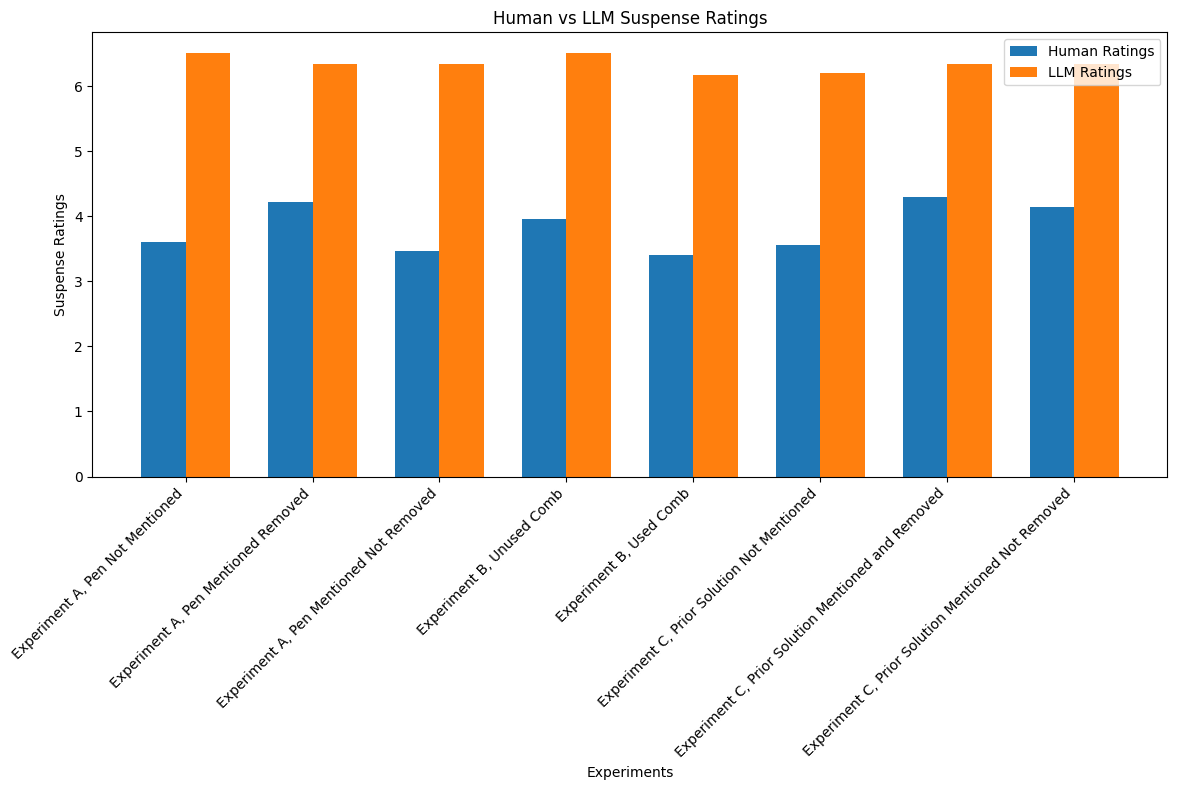

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
experiments = list(human_ratings.keys())
llm_values = [llm_ratings.get(exp, 0) for exp in experiments]
human_values = [human_ratings.get(exp, 0) for exp in experiments]

# Bar width and index positions
bar_width = 0.35
index = np.arange(len(experiments))

# Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Bars for human and LLM ratings
bars1 = ax.bar(index, human_values, bar_width, label='Human Ratings')
bars2 = ax.bar(index + bar_width, llm_values, bar_width, label='LLM Ratings')

# Labels and title
ax.set_xlabel('Experiments')
ax.set_ylabel('Suspense Ratings')
ax.set_title('Human vs LLM Suspense Ratings')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(experiments, rotation=45, ha='right', fontsize=10)
ax.legend()

# Show plot
plt.tight_layout()
plt.show()